In [16]:
from huggingface_hub import login
login()

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

In [18]:
# Clear MPS cache
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
    
# Also clear any cached gradients
import gc
gc.collect()

8300

In [19]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
model_name = "microsoft/phi-3-mini-4k-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLUActivation()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_featur

In [20]:
text = "Citron: Acide\nSucre: Sucré\nPiment: Épicé\nMiel:"
text_tokenized = tokenizer.encode(text, return_tensors="pt").to(device)
output = model.generate(text_tokenized, num_beams=4, max_new_tokens=3, do_sample=True)
text_decoded = tokenizer.decode(output[0])
print(text_decoded)

Citron: Acide
Sucre: Sucré
Piment: Épicé
Miel: Doux



In [21]:
def decode_token_with_logitlens(model, device, tokenizer, input, tokens_to_gen=None): 
    '''
    outputs a dictionary with {'decoded_tokens': [num_layers, seq_len], 'decoded_logits': [num_layers, seq_len]}
    '''
    inputs = tokenizer(input, return_tensors="pt").to(device)
    
    text = tokenizer.decode(inputs['input_ids'][0])
    # run the loop to generate new tokens after input, append to input and decode 
    if tokens_to_gen != None: 
        # generate new tokens all at once; then append them to input, then logitlens them all
        output = model.generate(
            inputs['input_ids'],
            do_sample=True,
            top_p=0.95,
            temperature=0.001,
            top_k=0,
            max_new_tokens=tokens_to_gen,
            )
        new_token = tokenizer.decode(output[0][-tokens_to_gen:])
        text += new_token
        inputs = tokenizer(text, return_tensors="pt").to(device)
    text_tokens = [tokenizer.decode(id) for id in inputs['input_ids'][0]]
    
    # apply decoder lens
    classifier_head = model.lm_head # Linear(in_features=3072, out_features=32064, bias=False)

    hidden_states = model(**inputs, output_hidden_states = True).hidden_states
    decoded_intermediate_token = {}
    decoded_intermediate_logit = {}
    with torch.no_grad():
        for layer_id in range(len(hidden_states)): 
            hidden_state = hidden_states[layer_id]
            decoded_value = classifier_head(hidden_state) # [batch, seq_len, vocab_size]
            # get probabilities
            decoded_values = torch.nn.functional.softmax(decoded_value, dim=-1)
            # take max element
            argmax = torch.argmax(decoded_values, dim=-1)[0] # select first element in batch
            # decode all tokens
            decoded_token = [tokenizer.decode(int(el)) for el in argmax]
            decoded_logit = [decoded_values[0, it, argmax[it]].item() for it in range(len(argmax))] # list of layers, per layer the sequence_length
            decoded_intermediate_token[layer_id] = decoded_token
            decoded_intermediate_logit[layer_id] = decoded_logit

    tokens = list(decoded_intermediate_token.values()) # [num_layers, seq_len]
    logits = list(decoded_intermediate_logit.values()) # [num_layers, seq_len]
    return {'text_tokens':text_tokens, 'decoded_tokens': tokens, 'decoded_logits': logits}

In [22]:
dict_output = decode_token_with_logitlens(model, device, tokenizer, text, tokens_to_gen=2)
decoded_tokens = dict_output['decoded_tokens']
decoded_logits = dict_output['decoded_logits']
text_tokens = dict_output['text_tokens']
print(len(text_tokens), text_tokens)

25 ['Cit', 'ron', ':', 'A', 'cide', '\n', 'Su', 'cre', ':', 'S', 'uc', 'ré', '\n', 'P', 'iment', ':', 'É', 'pic', 'é', '\n', 'M', 'iel', ':', 'D', 'oux']


In [23]:
for element in range(len(decoded_tokens)):
    print(decoded_tokens[element])

['izen', 'unci', 'Screen', 'bove', 'zat', 'Datos', 'ites', 'opening', 'Screen', 'orted', 'Stra', 'imas', 'Datos', 'rior', 'Db', 'Screen', 'cze', 'éd', 'parc', 'Datos', 'arch', 'merge', 'Screen', 'enis', 'Terr']
['míst', '☺', 'míst', 'míst', '🌍', 'míst', 'becom', 'míst', 'míst', '↵', '\x97', '̶', 'míst', '↵', 'hbox', 'míst', '̶', '\x97', '☺', 'míst', '↵', 'Ê', 'míst', '♯', 'Č']
['míst', '☺', 'míst', 'míst', '￼', 'míst', 'cí', 'míst', 'míst', 'míst', '›', '̶', 'míst', 'míst', 'ão', 'míst', '̶', '�', '☺', 'míst', 'cí', 'Vé', '─', '♯', 'Č']
['option', 'Niem', '\x97', 'mí', 'has', '\x97', '马', 'pick', 'infatti', '⇔', '›', 'men', '\x97', 'OL', 'wind', '\x97', '⇔', 'Sver', 'living', '\x97', '↵', 'Vé', '\x97', 'Martí', 'Č']
['option', 'ouc', 'highly', 'ero', 'practices', '\x97', 'ivi', 'int', 'infatti', 'míst', 'lande', 'ợ', '￼', 'OL', 'al', '\x97', '⟶', 'nic', 'surr', '\x97', '⇔', 'rig', '\x97', 'LT', 'fil']
['option', 'r', 'Fich', 'mí', 'ity', '￼', '⟶', 'at', 'Fich', 'echter', 'uro', 'exclus

In [24]:
tokens_viz = [tok for tok in decoded_tokens] # [num_layers, num_tokens]
logits_viz = np.array([log for log in decoded_logits]) # [num_layers, num_tokens]
a = [it for it in range(len(text_tokens))]
b = [tok for tok in text_tokens]
col_labels = [str(a_)+': '+b_ for a_, b_ in zip(a, b)]
norm = plt.Normalize(logits_viz.min()-1, logits_viz.max()+1)
colours = plt.cm.cool(norm(logits_viz))
fig, ax = plt.subplots(figsize=(20,5), dpi=1000)
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
img = plt.imshow(norm(logits_viz), cmap="cool")
plt.colorbar()
img.set_visible(False)
ax.table(cellText=tokens_viz, rowLabels=[lay for lay in range(len(decoded_tokens))], colLabels=col_labels, colWidths = [0.2]*logits_viz.shape[1], loc='center', cellColours=img.to_rgba(norm(logits_viz))) 
plt.show()

/Users/fletcaw1/Documents/Personal/personal-repos/andrewstephenfletcher.github.io/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/fletcaw1/Documents/Personal/personal-repos/andrewstephenfletcher.github.io/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/fletcaw1/Documents/Personal/personal-repos/andrewstephenfletcher.github.io/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/fletcaw1/Documents/Personal/personal-repos/andrewstephenfletcher.github.io/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12400 (\N{H

Full text tokens: ['Cit', 'ron', ':', 'A', 'cide', '\n', 'Su', 'cre', ':', 'S', 'uc', 'ré', '\n', 'P', 'iment', ':', 'É', 'pic', 'é', '\n', 'M', 'iel', ':', 'D', 'oux']
Miel starts at token index: None
Visualizing tokens 20 to 25: ['M', 'iel', ':', 'D', 'oux']


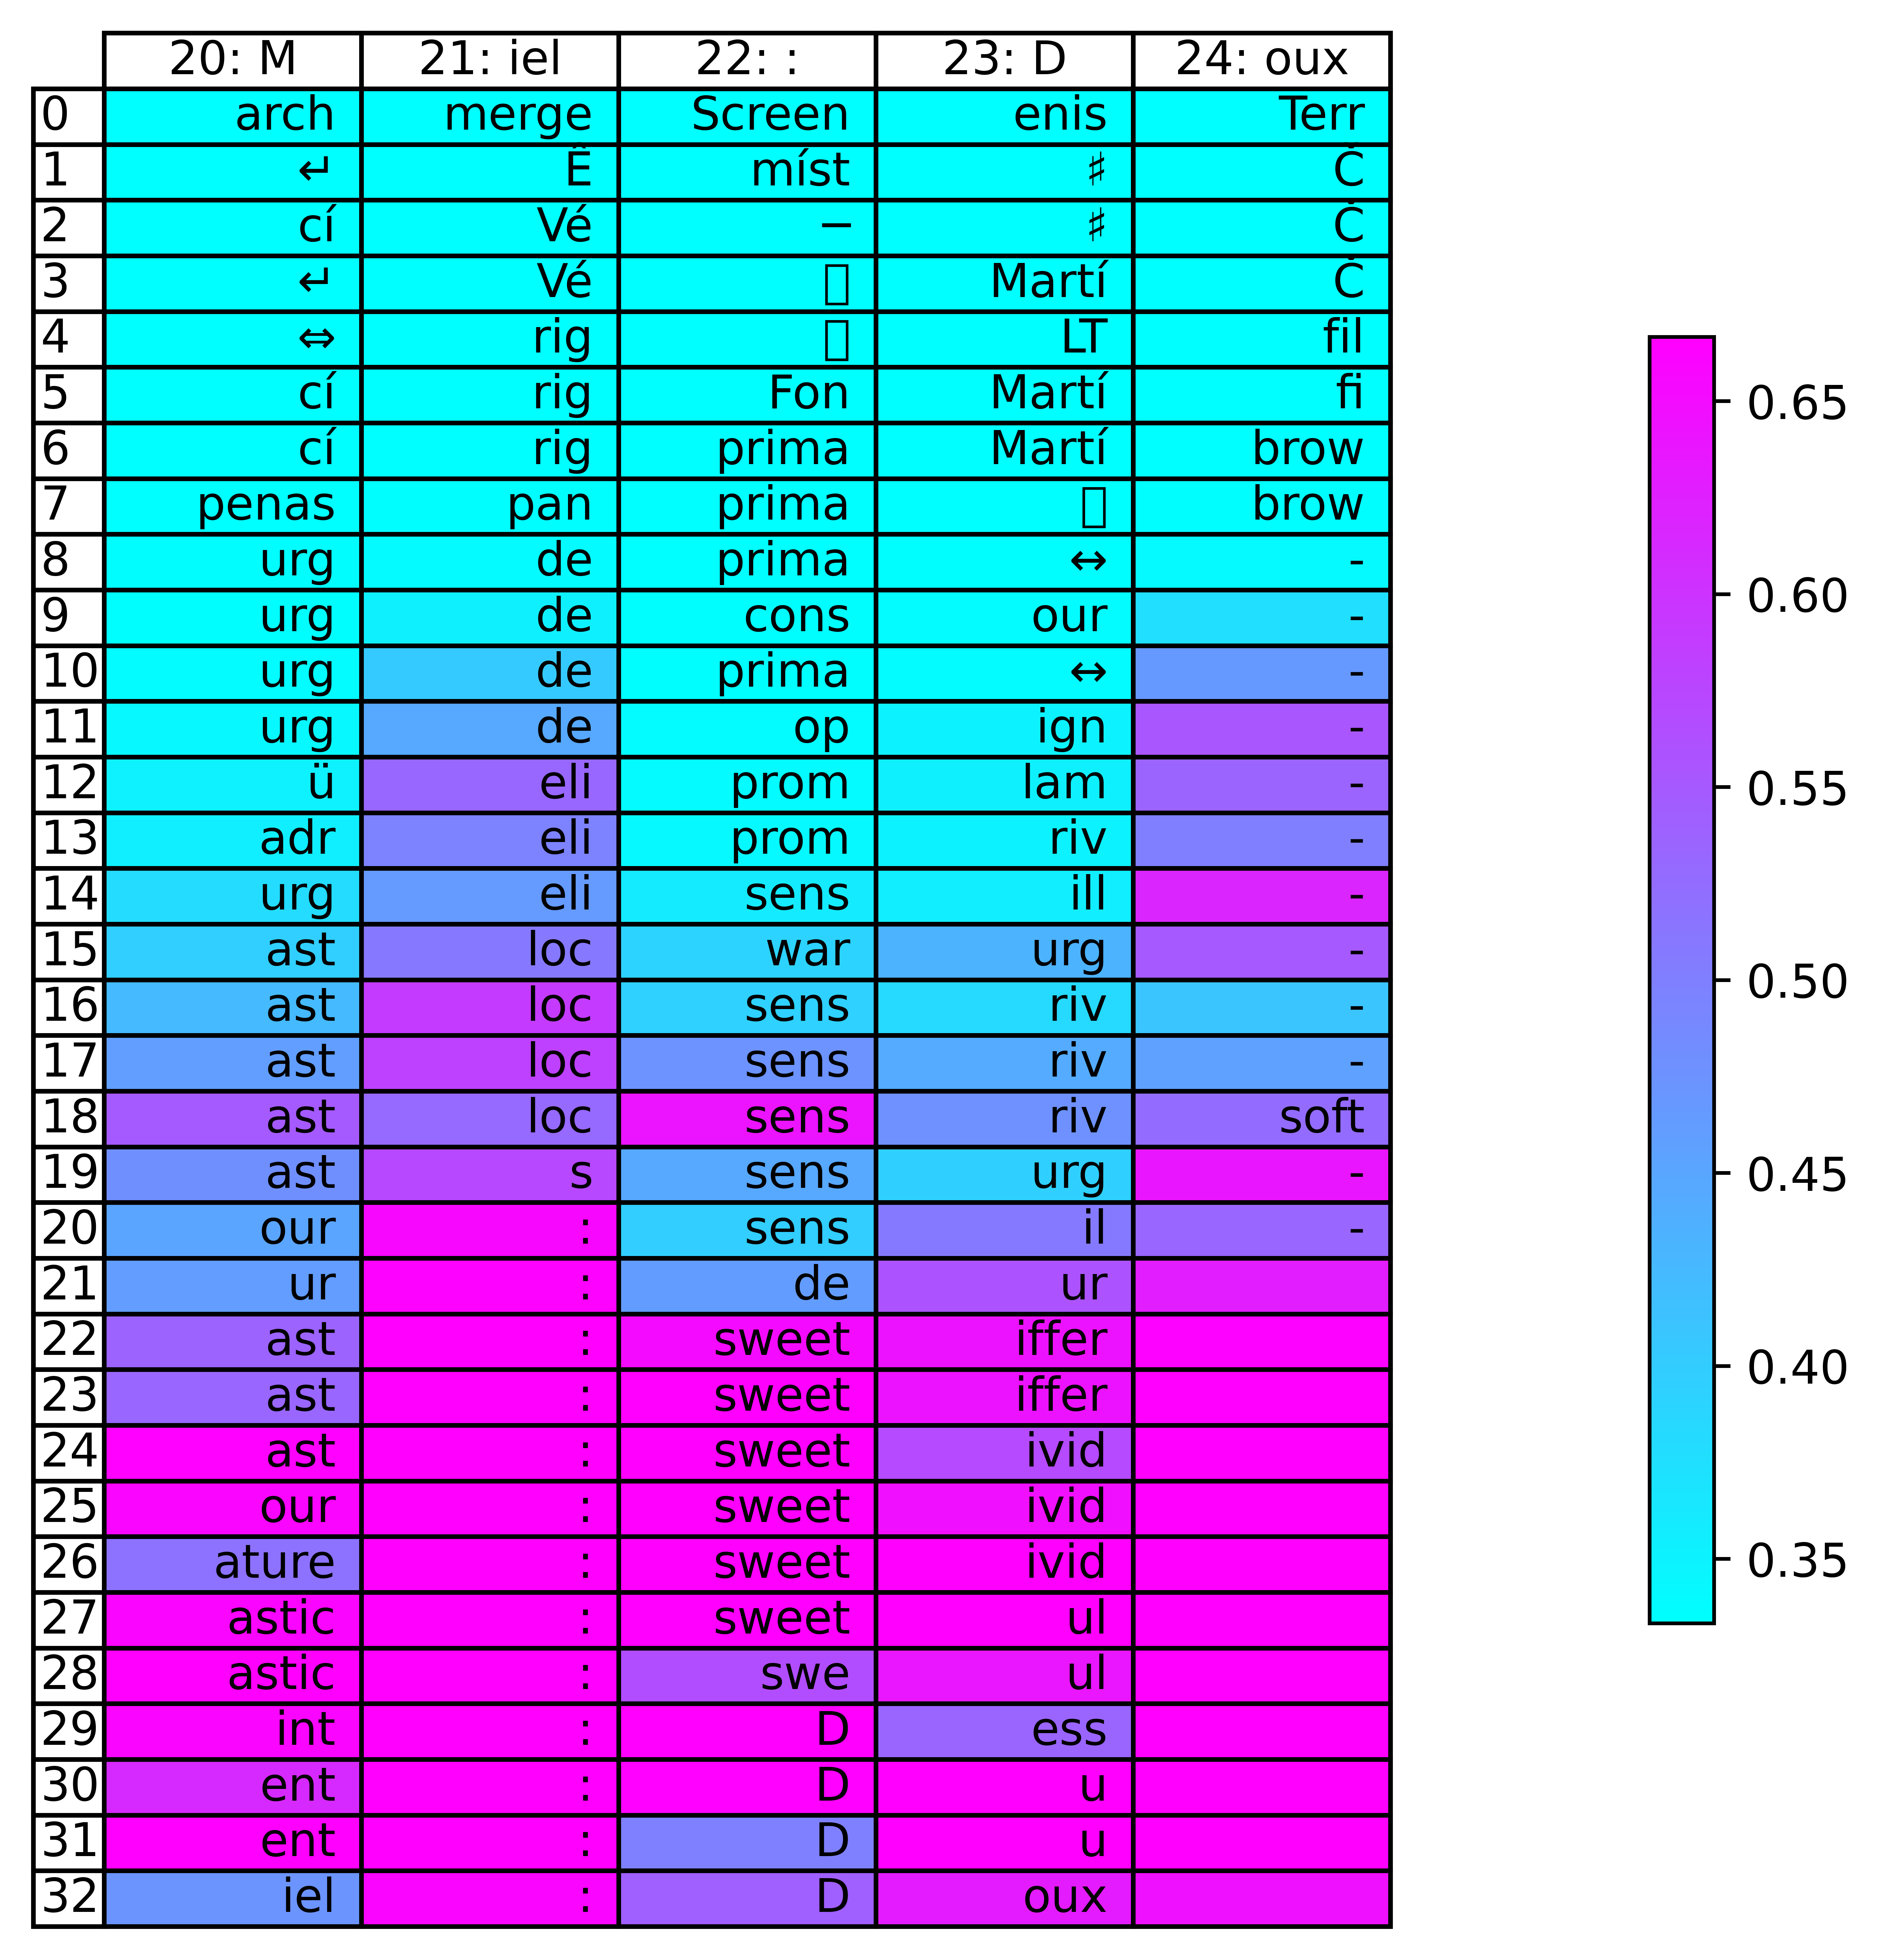

In [25]:
# Find where "Miel: Doux" tokens start
search_text = "Miel: Doux"
full_text = ''.join(text_tokens)

# Find the token indices for "Miel: Doux"
# First, let's see which tokens contain these characters
miel_start_idx = None
for i, token in enumerate(text_tokens):
    if "Miel" in token:
        miel_start_idx = i
        break

# Print to see what we found
print(f"Full text tokens: {text_tokens}")
print(f"Miel starts at token index: {miel_start_idx}")

# Let's look at a few tokens around "Miel:"
if miel_start_idx is not None:
    # Show tokens from Miel onwards (adjust range as needed)
    to_viz = (miel_start_idx, min(miel_start_idx + 5, len(text_tokens)))
else:
    # Fallback: show last few tokens if we can't find "Miel"
    to_viz = (max(0, len(text_tokens) - 5), len(text_tokens))

print(f"Visualizing tokens {to_viz[0]} to {to_viz[1]}: {text_tokens[to_viz[0]:to_viz[1]]}")

tokens_viz = [tok[to_viz[0]:to_viz[1]] for tok in decoded_tokens]
logits_viz = np.array([logit[to_viz[0]:to_viz[1]] for logit in decoded_logits])
a = [it for it in range(to_viz[0], to_viz[1])]
b = [tok for tok in text_tokens[to_viz[0]:to_viz[1]]]
col_labels = [str(a_)+': '+b_ for a_, b_ in zip(a, b)]
norm = plt.Normalize(logits_viz.min()-1, logits_viz.max()+1)
colours = plt.cm.cool(norm(logits_viz))
fig, ax = plt.subplots(figsize=(20,5), dpi=1000)
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
img = plt.imshow(norm(logits_viz), cmap="cool")
plt.colorbar()
img.set_visible(False)
ax.table(cellText=tokens_viz, rowLabels=[lay for lay in range(len(decoded_tokens))], colLabels=col_labels, colWidths = [0.2]*logits_viz.shape[1], loc='center', cellColours=img.to_rgba(norm(logits_viz))) 
plt.show()

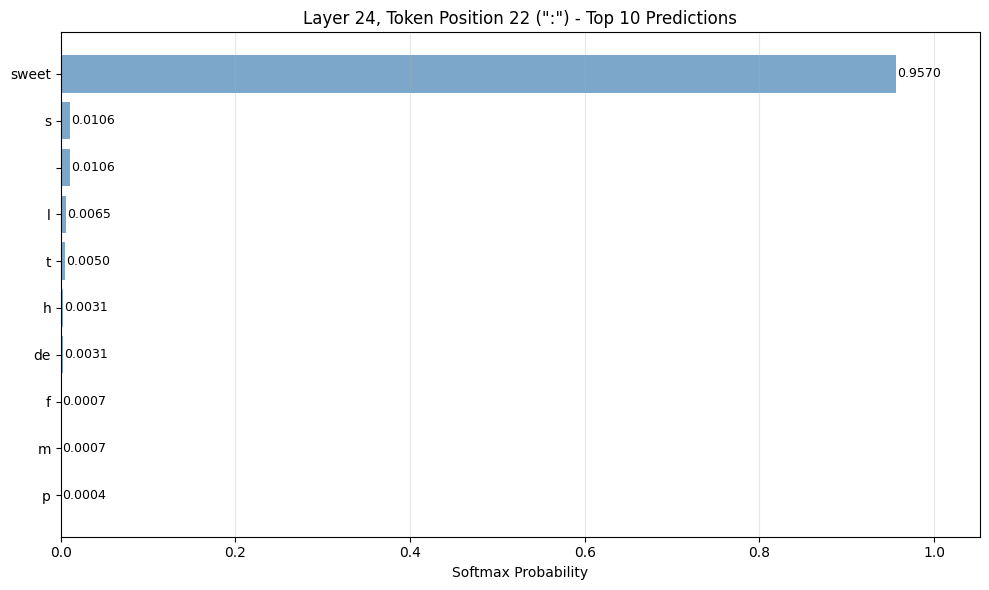

In [33]:
import matplotlib.pyplot as plt
import torch


inputs = tokenizer(text, return_tensors="pt").to(device)

# Get the hidden state at layer 24, token position 22
layer_24_hidden = model(**tokenizer(tokenizer.decode(inputs['input_ids'][0]), 
                                    return_tensors="pt").to(device), 
                                    output_hidden_states=True).hidden_states[22]

# Apply classifier head to get logits for all vocabulary
with torch.no_grad():
    logits = model.lm_head(layer_24_hidden[0, 22, :])  # [vocab_size]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # Get top 10
    top_10_probs, top_10_indices = torch.topk(probs, 10)
    
    # Decode tokens
    top_10_tokens = [tokenizer.decode(int(idx)) for idx in top_10_indices]
    top_10_probs = top_10_probs.float().cpu().numpy()  # Convert to float32 first

# Reverse for display (highest at top)
top_10_tokens = top_10_tokens[::-1]
top_10_probs = top_10_probs[::-1]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

y_positions = range(len(top_10_tokens))
ax.barh(y_positions, top_10_probs, color='steelblue', alpha=0.7)

ax.set_yticks(y_positions)
ax.set_yticklabels([f"{token}" for token in top_10_tokens])
ax.set_xlabel('Softmax Probability')
ax.set_title(f'Layer 24, Token Position 22 ("{text_tokens[22]}") - Top 10 Predictions')
ax.set_xlim(0, max(top_10_probs) * 1.1)

ax.grid(axis='x', alpha=0.3)

for i, prob in enumerate(top_10_probs):
    ax.text(prob + 0.001, i, f'{prob:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

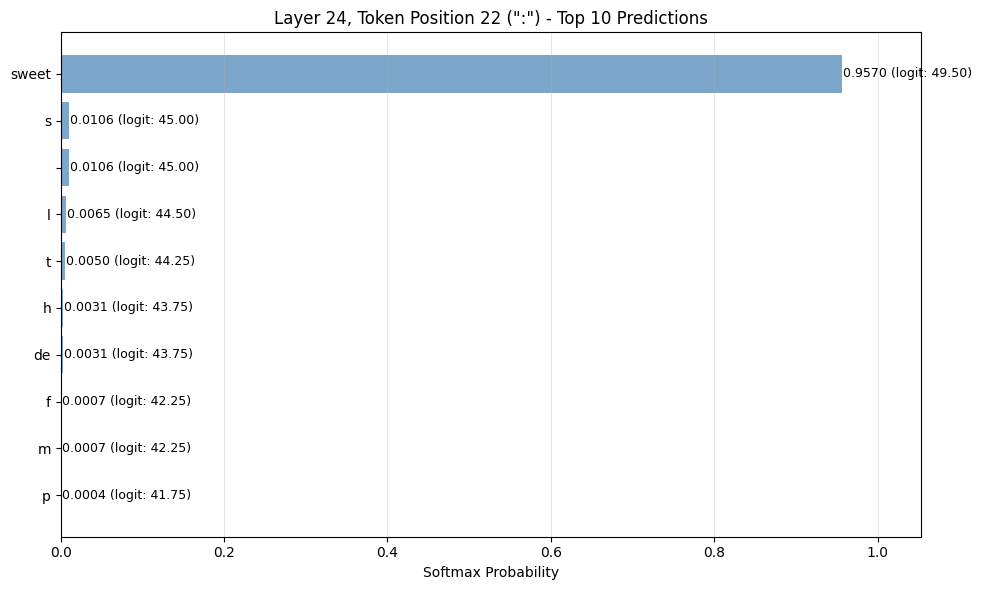

In [34]:
import matplotlib.pyplot as plt
import torch


inputs = tokenizer(text, return_tensors="pt").to(device)

# Get the hidden state at layer 24, token position 22
layer_24_hidden = model(**tokenizer(tokenizer.decode(inputs['input_ids'][0]), 
                                    return_tensors="pt").to(device), 
                                    output_hidden_states=True).hidden_states[22]

# Apply classifier head to get logits for all vocabulary
with torch.no_grad():
    logits = model.lm_head(layer_24_hidden[0, 22, :])  # [vocab_size]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # Get top 10
    top_10_probs, top_10_indices = torch.topk(probs, 10)
    
    # Get corresponding logits
    top_10_logits = logits[top_10_indices]
    
    # Decode tokens
    top_10_tokens = [tokenizer.decode(int(idx)) for idx in top_10_indices]
    top_10_probs = top_10_probs.float().cpu().numpy()
    top_10_logits = top_10_logits.float().cpu().numpy()

# Reverse for display (highest at top)
top_10_tokens = top_10_tokens[::-1]
top_10_probs = top_10_probs[::-1]
top_10_logits = top_10_logits[::-1]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

y_positions = range(len(top_10_tokens))
ax.barh(y_positions, top_10_probs, color='steelblue', alpha=0.7)

ax.set_yticks(y_positions)
ax.set_yticklabels([f"{token}" for token in top_10_tokens])
ax.set_xlabel('Softmax Probability')
ax.set_title(f'Layer 24, Token Position 22 ("{text_tokens[22]}") - Top 10 Predictions')
ax.set_xlim(0, max(top_10_probs) * 1.1)

ax.grid(axis='x', alpha=0.3)

for i, (prob, logit) in enumerate(zip(top_10_probs, top_10_logits)):
    ax.text(prob + 0.001, i, f'{prob:.4f} (logit: {logit:.2f})', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# import pickle

# # Save
# with open('logit_lens_results.pkl', 'wb') as f:
#     pickle.dump(dict_output, f)

# # Load later
# with open('logit_lens_results.pkl', 'rb') as f:
#     dict_output = pickle.load(f)
#     decoded_tokens = dict_output['decoded_tokens']
#     decoded_logits = dict_output['decoded_logits']
#     text_tokens = dict_output['text_tokens']